In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\root\src")
from InflationFactorGenerator import FactorModel

## Prepping data

In [3]:
def get_factor_rtn() -> pd.DataFrame: 
    
    df_factor_rtn = (FactorModel().generate_factor()[
        ["name", "variable", "lag_decile", "date", "factor_rtn"]].
        groupby(["name", "variable", "lag_decile", "date"]).
        agg("sum").
        reset_index())
    
    return df_factor_rtn

df_factor_rtn = get_factor_rtn()

## CPI Z-Score Approach

Using the approach in this paper [*Capital Fund Management: Inflationary Regimes and Asset Class Performance*](https://www.cfm.com/inflationary-regimes-and-asset-class-performance/)

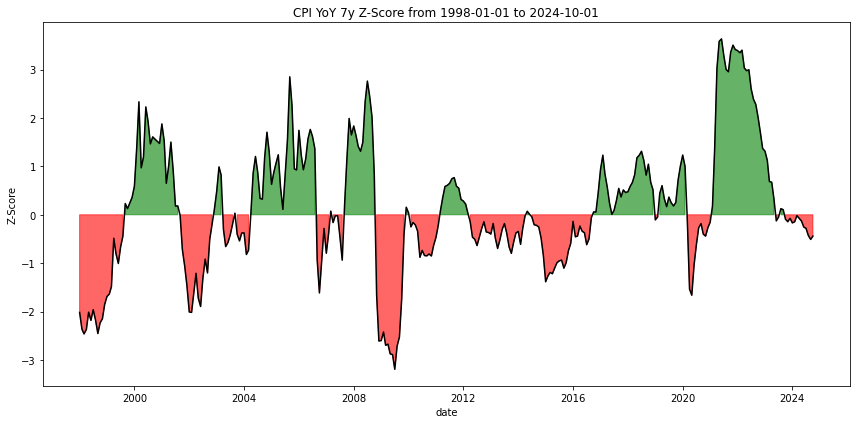

In [4]:
def plot_inflation_zscore() -> plt.Figure: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    df_tmp = (FactorModel().prep_inflation_data().set_index(
        "date")
        [["z_score"]])

    (df_tmp.plot(
        ax     = axes,
        legend = False,
        ylabel = "Z-Score",
        color  = "black",
        title  = "CPI YoY 7y Z-Score from {} to {}".format(
            df_tmp.index.min(),
            df_tmp.index.max())))

    axes.fill_between(
        x     = df_tmp.index,
        y1    = 0,
        y2    = df_tmp.z_score,
        where = 0 > df_tmp.z_score,
        color = "red",
        alpha = 0.6)

    axes.fill_between(
        x     = df_tmp.index,
        y1    = 0,
        y2    = df_tmp.z_score,
        where = 0 < df_tmp.z_score,
        color = "green",
        alpha = 0.6)
    
    plt.tight_layout()
    
plot_inflation_zscore()

Start by grouping the returns based on the z-score of the each decile of the factors. 

In [5]:
def get_inflation_leg_sharpe() -> pd.DataFrame: 
    
    df_inflation_tmp = (get_factor_rtn().assign(
        date = lambda x: pd.to_datetime(x.date).dt.strftime("%Y-%m")))

    df_cpi_prep = (FactorModel().prep_inflation_data().assign(
        date = lambda x: pd.to_datetime(x.date).dt.strftime("%Y-%m")))

    df_rtn = (df_inflation_tmp.merge(
        right = df_cpi_prep, how = "inner", on = ["date"]).
        assign(z_score_group = lambda x: np.where(x.z_score < 0, "Low Inflation", "High Inflation"))
        [["name", "variable", "lag_decile", "factor_rtn", "z_score_group"]].
        groupby(["name", "variable", "lag_decile", "z_score_group"]).
        agg(["mean", "std"])
        ["factor_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        dropna().
        reset_index())
    
    return df_rtn

df_inflation_leg_sharpe = get_inflation_leg_sharpe()

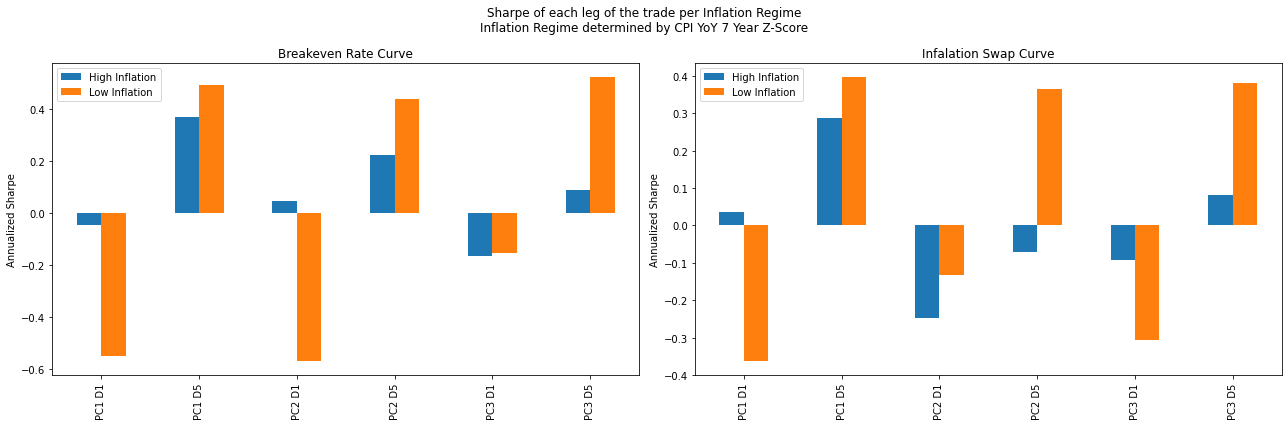

In [6]:
def plot_inflation_leg_regime(df_inflation_leg_sharpe: pd.DataFrame) -> pd.DataFrame: 
    
    renamer = {
        "BreakevenRate" : "Breakeven Rate Curve",
        "InflationSwaps": "Infalation Swap Curve"}
    
    df_tmp = (df_inflation_leg_sharpe.assign(
        strat_name = lambda x: x.variable + " " + x.lag_decile.astype(str)))

    group_vars = df_tmp.name.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (18,6))

    for group_var, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "name == @group_var")
            [["strat_name", "z_score_group", "sharpe"]].
            rename(columns = {"z_score_group": ""}).
            pivot(index = "strat_name", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                ylabel = "Annualized Sharpe",
                title  = renamer[group_var],
                xlabel = ""))

    fig.suptitle("Sharpe of each leg of the trade per Inflation Regime\nInflation Regime determined by CPI YoY 7 Year Z-Score")
    plt.tight_layout()
    
plot_inflation_leg_regime(df_inflation_leg_sharpe)

In [7]:
def get_ls_factor_rtn(df_factor_rtn: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df_factor_rtn.assign(
        lag_decile = lambda x: x.lag_decile.astype(str)).
        pivot(index = ["date", "name", "variable"], columns = "lag_decile", values = "factor_rtn").
        reset_index().
        assign(factor_rtn = lambda x: x.D5 - x.D1)
        [["date", "name", "variable", "factor_rtn"]])
    
    return df_out

df_ls_factor_rtn = get_ls_factor_rtn(df_factor_rtn)

In [8]:
def get_ls_inflation_sharpe(df_ls_factor_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_ls_prep = (df_ls_factor_rtn.assign(
        date = lambda x: pd.to_datetime(x.date).dt.strftime("%Y-%m")))

    df_cpi_prep = (FactorModel().prep_inflation_data().assign(
        date = lambda x: pd.to_datetime(x.date).dt.strftime("%Y-%m")))

    df_out = (df_ls_prep.merge(
        right = df_cpi_prep, how = "inner", on = ["date"]).
        assign(z_score_group = lambda x: np.where(x.z_score < 0, "Low Inflation", "High Inflation"))
        [["z_score_group", "name", "variable", "factor_rtn"]].
        groupby(["z_score_group", "name", "variable"]).
        agg(["mean", "std"])
        ["factor_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_out

df_ls_inflation_sharpe = get_ls_inflation_sharpe(df_ls_factor_rtn)

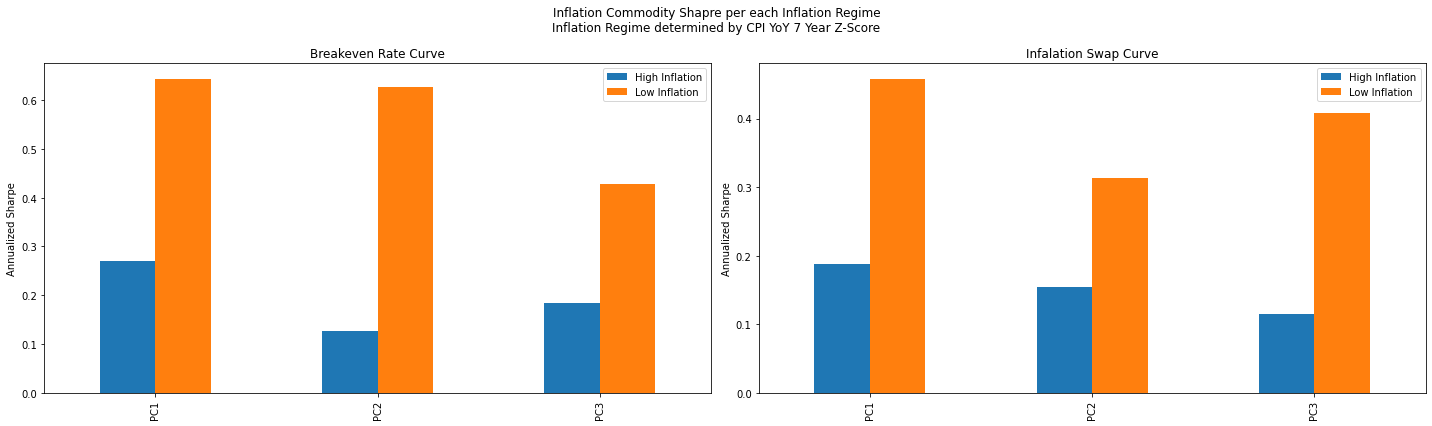

In [9]:
def plot_ls_inflation_sharpe(df_ls_inflation_sharpe: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "BreakevenRate" : "Breakeven Rate Curve",
        "InflationSwaps": "Infalation Swap Curve"}

    fig, axes = plt.subplots(ncols = len(renamer.keys()), figsize = (20,6))

    for name, ax in zip(renamer.keys(), axes.flatten()): 

        (df_ls_inflation_sharpe.query(
            "name == @name")
            [["z_score_group", "variable", "sharpe"]].
            rename(columns = {"z_score_group": ""}).
            pivot(index = "variable", columns = "", values = "sharpe").
            plot(
                ax      = ax,
                kind    = "bar",
                ylabel  = "Annualized Sharpe",
                xlabel  = "",
                title   = renamer[name]))

    fig.suptitle("Inflation Commodity Shapre per each Inflation Regime\nInflation Regime determined by CPI YoY 7 Year Z-Score")
    plt.tight_layout()
    
plot_ls_inflation_sharpe(df_ls_inflation_sharpe)

## Commodity Exposure Analysis

In [10]:
def _get_month_end(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.set_index(
        "date").
        resample("1m").
        first().
        drop(columns = ["security"]).
        sort_values("date").
        assign(PX_mnth_rtn = lambda x: x.value.pct_change()).
        dropna())
    
    return df_out

def get_index_rtn() -> pd.DataFrame: 

    df_out = (FactorModel().get_misc_indices().groupby(
        "security").
        apply(_get_month_end).
        reset_index())
    
    return df_out

df_index_rtn = get_index_rtn()

In [11]:
def _get_monthly_rtn(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        assign(cum_rtn = lambda x: np.cumprod(1 + x.factor_rtn) - 1).
        query("date == date.max()"))
    
    return df_out

def get_monthly_factor_leg_rtn() -> pd.DataFrame:

    df_tmp = (FactorModel().generate_factor()[
        ["name", "variable", "lag_decile", "factor_rtn", "date"]].
        groupby(["name", "variable", "lag_decile", "date"]).
        agg("sum").
        reset_index().
        assign(group_var = lambda x: x.name + "_" + x.variable + "_" + x.lag_decile.astype(str)))

    df_month_rtn = (df_tmp[
        ["group_var", "date", "factor_rtn"]].
        assign(
            year       = lambda x: pd.to_datetime(x.date).dt.year,
            month_date = lambda x: pd.to_datetime(x.date).dt.strftime("%Y-%m")).
        query("year >= 2000").
        groupby(["group_var", "month_date"]).
        apply(_get_monthly_rtn).
        reset_index(drop = True))

    df_namer = (df_tmp.drop(
        columns = ["date", "factor_rtn"]).
        drop_duplicates())

    df_out = (df_month_rtn.merge(
        right = df_namer, how = "inner", on = ["group_var"]))
    
    return df_out

df_factor_leg_monthly = get_monthly_factor_leg_rtn()

In [12]:
def _get_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    model = (sm.OLS(
        endog = df.cum_rtn,
        exog  = sm.add_constant(df.PX_mnth_rtn)).
        fit())

    df_out = model.params.to_frame(name = "param_val")
    return df_out

def get_leg_monthly_ols(df_index_rtn: pd.DataFrame, df_factor_leg_monthly: pd.DataFrame) -> pd.DataFrame:

    df_combined = (df_index_rtn.assign(
        month_date = lambda x: pd.to_datetime(x.date).dt.strftime("%Y-%m")).
        drop(columns = ["date"]).
        merge(right = df_factor_leg_monthly, how = "inner", on = ["month_date"]).
        drop(columns = ["date"]).
        assign(group_var = lambda x: x.group_var + "_" + x.security))

    df_namer = (df_combined[
        ["group_var", "name", "variable", "lag_decile", "security"]].
        drop_duplicates())

    df_out = (df_combined.groupby(
        "group_var").
        apply(_get_ols).
        reset_index().
        rename(columns = {"level_1": "param"}).
        merge(right = df_namer, how = "inner", on = ["group_var"]).
        query("lag_decile == ['D1', 'D5']"))
    
    return df_out

df_leg_monthly_ols = get_leg_monthly_ols(df_index_rtn, df_factor_leg_monthly)

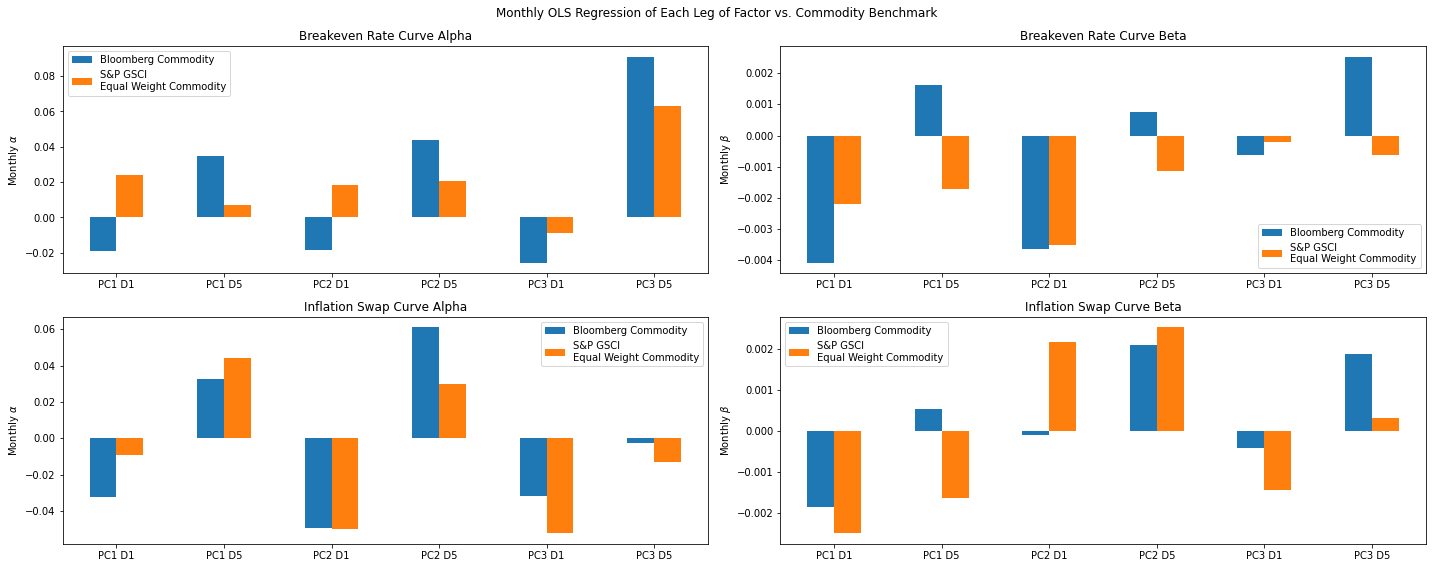

In [13]:
def plot_monthly_ols(df_leg_monthly_ols: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        "BreakevenRate" : "Breakeven Rate Curve",
        "InflationSwaps": "Infalation Swap Curve"}

    df_tmp = (df_leg_monthly_ols.drop(
        columns = ["group_var"]).
        assign(
            param_namer = lambda x: np.where(x.param == "const", "beta", "alpha"),
            tmp         = lambda x: x.variable + " " + x.lag_decile.astype(str),
            name        = lambda x: np.where(x.name == "BreakevenRate", "Breakeven Rate Curve", "Inflation Swap Curve"),
            tmp_name    = lambda x: x.name + " " + x.param_namer))

    df_namer = (FactorModel().get_misc_indices()[
        ["security", "description"]].
        drop_duplicates().
        assign(description = lambda x: x.description.str.split("y").str[0].str.replace("CI ", "CI\n").str.strip() + "y"))

    tmp_name  = r"Monthly $\beta$"
    names     = df_tmp.tmp_name.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(names) // 2, nrows = len(names) // 2, figsize = (20,8))

    for name, ax in zip(names, axes.flatten()): 

        if name.split(" ")[-1] == "alpha": ylabel = r"Monthly $\alpha$"
        else                             : ylabel = r"Monthly $\beta$"

        (df_tmp.query(
            "tmp_name == @name").
            merge(right = df_namer, how = "inner", on = ["security"])
            [["tmp", "param_val", "description"]].
            rename(columns = {"description": ""}).
            pivot(index = "tmp", columns = "", values = "param_val").
            plot(
                kind   = "bar",
                ax     = ax,
                xlabel = "",
                title  = name.title(),
                ylabel = ylabel))

        ax.tick_params(axis = "x", rotation = 0)

    fig.suptitle("Monthly OLS Regression of Each Leg of Factor vs. Commodity Benchmark")
    plt.tight_layout()
    
plot_monthly_ols(df_leg_monthly_ols)

In [14]:
def get_ls_monthly_rtn(df_ls_factor_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_ls_monthly = (df_ls_factor_rtn.assign(
        date_month = lambda x: pd.to_datetime(x.date).dt.strftime("%Y-%m")).
        groupby(["name", "variable", "date_month"]).
        apply(_get_monthly_rtn).
        reset_index(drop = True))
    
    return df_ls_monthly

df_ls_monthly = get_ls_monthly_rtn(df_ls_factor_rtn)

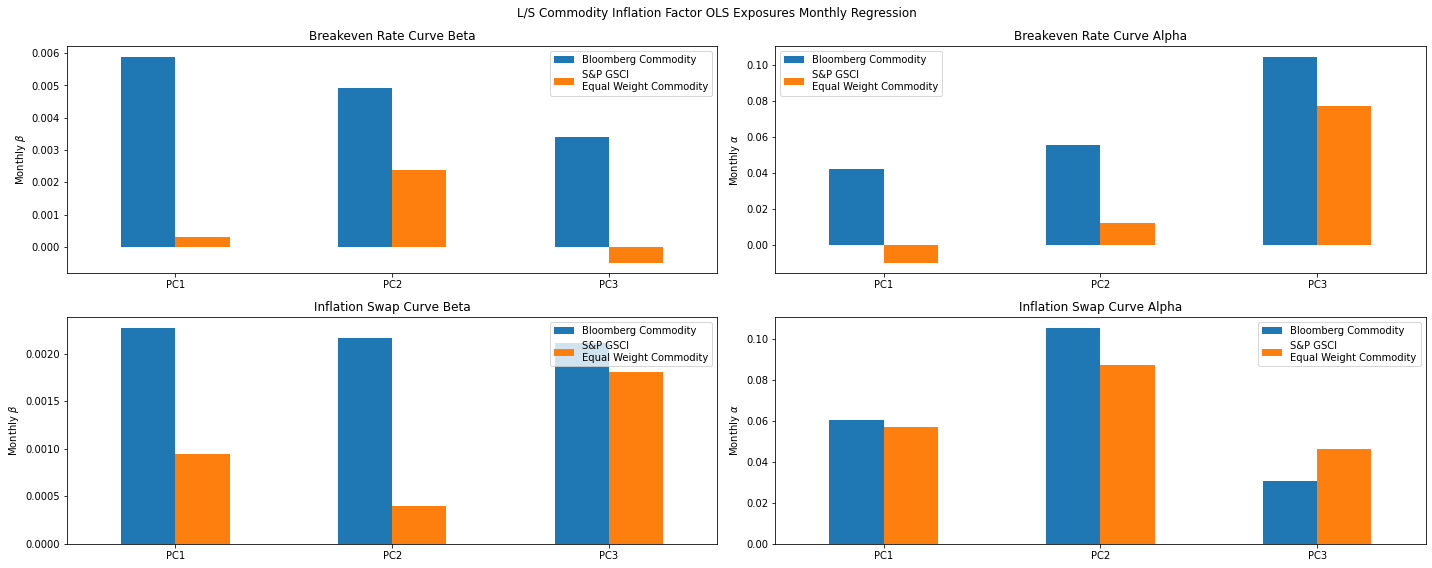

In [15]:
def plot_ls_monthly_ols(df_index_rtn: pd.DataFrame, df_ls_monthly: pd.DataFrame) -> plt.Figure:
    
    df_tmp = (df_index_rtn.assign(
        date_month = lambda x: pd.to_datetime(x.date).dt.strftime("%Y-%m")).
        drop(columns = ["date"]).
        merge(right = df_ls_monthly, how = "inner", on = ["date_month"]).
        assign(group_var = lambda x: x.security + " " + x.name + " " + x.variable))

    df_namer = (df_tmp[
        ["group_var", "description", "variable", "name"]].
        drop_duplicates().
        assign(description = lambda x: x.description.str.split("y").str[0].str.replace("CI ", "CI\n").str.strip() + "y"))

    df_plot = (df_tmp.groupby(
        "group_var").
        apply(_get_ols).
        reset_index().
        rename(columns = {"level_1": "param"}).
        merge(right = df_namer, how = "inner", on = ["group_var"]).
        drop(columns = ["group_var"]).
        assign(name = lambda x: np.where(x.name == "BreakevenRate", "Breakeven Rate Curve", "Inflation Swap Curve")).
        assign(
            param = lambda x: np.where(x.param == "const", "Beta", "Alpha"),
            name  = lambda x: x.name + " " + x.param))

    tmps      = df_plot.name.drop_duplicates().to_list()
    fig, axes = plt.subplots(ncols = len(tmps) // 2, nrows = len(tmps) // 2, figsize = (20,8))

    for tmp, ax in zip(tmps, axes.flatten()):

        if tmp.split(" ")[-1] == "Beta": ylabel = r"$\beta$"
        else                           : ylabel = r"$\alpha$"

        (df_plot.query(
            "name == @tmp")
            [["variable", "description", "param_val"]].
            rename(columns = {"description": ""}).
            pivot(index = "variable", columns = "", values = "param_val").
            plot(
                ax     = ax,
                kind   = "bar",
                ylabel = "Monthly " + ylabel,
                title  = tmp,
                xlabel = ""))

        ax.tick_params(axis = "x", rotation = 0)

    fig.suptitle("L/S Commodity Inflation Factor OLS Exposures Monthly Regression")
    plt.tight_layout()
    
plot_ls_monthly_ols(df_index_rtn, df_ls_monthly)